# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Package Import

In [1]:
# Import necessary packages
import os
import json
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights
from torchvision import datasets, transforms, models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

## Definition of paths to datasets

In [2]:
# Define file/folder paths
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define a function to load the data and perform associated operations
def load_data(data_dir):
    """Initialize data transforms, datasets, dataloaders, and related variables.

    Args:
    data_dir (str): Path to the main data directory.

    Returns:
    tuple: Data transforms, image datasets, dataloaders, dataset sizes, and class names.
    """
    # Define the paths to the datasets
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    test_dir = os.path.join(data_dir, 'test')

    # Define the transforms for the training, validation, and testing sets
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load the datasets with ImageFolder
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
        'val': datasets.ImageFolder(valid_dir, transform=data_transforms['val']),
        'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    }

    # Using the image datasets and the transforms, define the dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
        'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
        'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes

    return data_transforms, image_datasets, dataloaders, dataset_sizes, class_names

In [4]:
# Call the function to load the data and perform associated operations
data_transforms, image_datasets, dataloaders, dataset_sizes, class_names = load_data(data_dir)

In [5]:
# Check the distribution of the datasets
dataset_sizes

{'train': 6552, 'val': 818, 'test': 821}

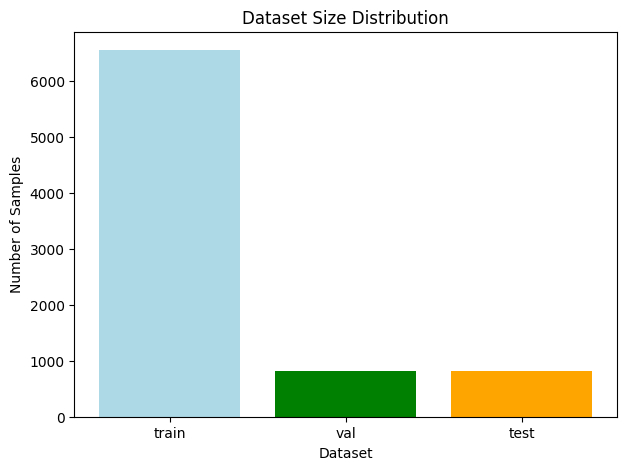

In [6]:
# View the distribution of the dataset
labels = list(dataset_sizes.keys())
sizes = list(dataset_sizes.values())

# Create the bar chart
plt.figure(figsize=(7, 5))  # Adjust figure size as needed
plt.bar(labels, sizes, color=['lightblue', 'green', 'orange'])  # Customize colors

# Set labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Dataset Size Distribution')

# Show the plot
plt.show()

## Check GPU availability

In [7]:
# Display information about NVIDIA GPUs on the machine(s)
!nvidia-smi

Tue Jan 14 08:45:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77.01              Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              4W /   35W |     550MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Check if a CUDA-capable GPU is available and set the device accordingly
if torch.cuda.is_available():
    print('-' * 60)
    print(f"We have {torch.cuda.device_count()} GPU(s) available, shown below:\n")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        device = torch.device("cuda:0")
        print(f"\nUsing {torch.cuda.get_device_name(i)} for the training.")
        print('-' * 60)
else:
    device = torch.device("cpu")
    print("GPU is not available or not selected. Using CPU for the code run.")

------------------------------------------------------------
We have 1 GPU(s) available, shown below:

GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU

Using NVIDIA GeForce RTX 4060 Laptop GPU for the training.
------------------------------------------------------------


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
# Mapping of labels to their associated names
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [10]:
# Print the dictionary to verify the mappings
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Load a Pre-trained Network

In [11]:
# Load a pre-trained VGG model with the appropriate weights
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

## Define a New, Untrained Feed-Forward Network

In [12]:
# Define a function to define the feed-forward network
def set_classifier(model, device):
    """Define and set a new feed-forward network as a classifier and move the model to the device.
    
    Args:
    model (torch.nn.Module): The model to which the classifier will be attached.
    device (torch.device): The device to which the model will be moved.
    
    Returns:
    torch.nn.Module: The model with the new classifier attached.
    """
    # Define a new feed-forward network as a classifier
    classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 102),
        nn.LogSoftmax(dim=1)
    )
    
    # Replace the model's classifier
    model.classifier = classifier
    
    # Move the model to the device
    model = model.to(device)
    
    return model

In [13]:
# Call the function to define the feed-forward network
model = set_classifier(model, device)

## Train the Classifier Layers

In [14]:
# Define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)

In [15]:
# Define a function to train the model with the train dataset
def train_model(model, criterion, optimizer, num_epochs):
    """
    Train the model on the training data and validate it on the validation data.

    Args:
    model (torch.nn.Module): The neural network model to be trained.
    criterion (torch.nn.Module): The loss function to optimize.
    optimizer (torch.optim.Optimizer): The optimizer to use for weight updates.
    num_epochs (int): The number of epochs to train the model.

    Returns:
    torch.nn.Module: The trained model.
    """
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [16]:
# Train the model
model = train_model(model, criterion, optimizer, 10)

Epoch 0/9
----------
train Loss: 2.9276 Acc: 0.3976
val Loss: 0.9529 Acc: 0.7433
Epoch 1/9
----------
train Loss: 1.6787 Acc: 0.5850
val Loss: 0.7820 Acc: 0.8044
Epoch 2/9
----------
train Loss: 1.5111 Acc: 0.6161
val Loss: 0.5844 Acc: 0.8460
Epoch 3/9
----------
train Loss: 1.4690 Acc: 0.6398
val Loss: 0.6340 Acc: 0.8264
Epoch 4/9
----------
train Loss: 1.3982 Acc: 0.6600
val Loss: 0.5404 Acc: 0.8570
Epoch 5/9
----------
train Loss: 1.3438 Acc: 0.6751
val Loss: 0.5262 Acc: 0.8741
Epoch 6/9
----------
train Loss: 1.3082 Acc: 0.6874
val Loss: 0.5619 Acc: 0.8680
Epoch 7/9
----------
train Loss: 1.3140 Acc: 0.6813
val Loss: 0.4637 Acc: 0.8936
Epoch 8/9
----------
train Loss: 1.2913 Acc: 0.6993
val Loss: 0.5010 Acc: 0.8753
Epoch 9/9
----------
train Loss: 1.2686 Acc: 0.7080
val Loss: 0.4851 Acc: 0.8802


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# Define a function to train the model with the test dataset
def test_model(model, dataloaders, dataset_sizes, device):
    """
    Test the trained network on test data and measure the accuracy.

    Args:
    model (torch.nn.Module): Trained model to be tested.
    dataloaders (dict): Dictionary containing 'train', 'val', and 'test' dataloaders.
    dataset_sizes (dict): Dictionary containing sizes of 'train', 'val', and 'test' datasets.
    device (torch.device): Device on which the model is being run.

    Returns:
    float: Accuracy of the model on test data.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize variables to track accuracy
    running_corrects = 0

    # Iterate over the test data
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Update the number of correct predictions
        running_corrects += torch.sum(preds == labels.data)

    # Calculate the accuracy
    test_accuracy = running_corrects.double() / dataset_sizes['test']
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    return test_accuracy

In [18]:
# Get the accuracy
test_accuracy = test_model(model, dataloaders, dataset_sizes, device)

Test Accuracy: 0.8733


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Save the Trained Model

In [19]:
# Define a function to save the trained model
def save_checkpoint(model, optimizer, epochs, path='checkpoint.pth'):
    """
    Save the trained model and necessary information for future inference or continued training.

    Args:
    model (torch.nn.Module): The trained model to be saved.
    optimizer (torch.optim.Optimizer): The optimizer used during training.
    epochs (int): The number of epochs the model was trained for.
    path (str): The file path to save the checkpoint.

    Returns:
    None
    """
    # Attach the class to index mapping to the model
    model.class_to_idx = image_datasets['train'].class_to_idx

    # Create a checkpoint dictionary
    checkpoint = {
        'arch': 'vgg16',
        'class_to_idx': model.class_to_idx,
        'state_dict': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epochs': epochs
    }

    # Save the checkpoint
    torch.save(checkpoint, path)
    print(f'Model checkpoint saved to {path}')

In [20]:
# Call the function to save the model
save_checkpoint(model, optimizer, 10, path='flower_classifier.pth')

Model checkpoint saved to flower_classifier.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
# Define a function to load the saved model
def load_checkpoint(filepath):
    """
    Load a checkpoint and rebuild the model.

    Args:
    filepath (str): Path to the checkpoint file.

    Returns:
    torch.nn.Module: The rebuilt model.
    """
    # Load the checkpoint
    checkpoint = torch.load(filepath, weights_only=True)
    
    # Rebuild the model architecture
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    
    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Define a new classifier
    classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 102),
        nn.LogSoftmax(dim=1)
    )
    
    # Attach the new classifier to the model
    model.classifier = classifier
    
    # Load the state_dict from the checkpoint
    model.load_state_dict(checkpoint['state_dict'])
    
    # Attach the class_to_idx mapping
    model.class_to_idx = checkpoint['class_to_idx']
    
    # Load the optimizer state_dict
    optimizer = torch.optim.Adam(model.classifier.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    
    # Retrieve the number of epochs
    epochs = checkpoint['epochs']
    
    print(f"Loaded checkpoint '{filepath}' with {epochs} epochs.")
    return model, optimizer, epochs

In [22]:
# Load the saved mmodel
model, optimizer, epochs = load_checkpoint('flower_classifier.pth')

Loaded checkpoint 'flower_classifier.pth' with 10 epochs.


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
# Define a function to pre-process input image(s)
def process_image(image_path):
    """Scales, crops, and normalizes a PIL image for a PyTorch model,
       returns a Numpy array.
       
    Args:
    image_path (str): Path to the image file.
    
    Returns:
    np.array: Processed image as a Numpy array.
    """
    # Open the image file
    image = Image.open(image_path)
    
    # Resize the image where the shortest side is 256 pixels, keeping the aspect ratio
    aspect = image.size[0] / float(image.size[1])
    if aspect > 1:
        image = image.resize((int(aspect * 256), 256))
    else:
        image = image.resize((256, int(256 / aspect)))
    
    # Crop out the center 224x224 portion of the image
    width, height = image.size
    new_width, new_height = 224, 224
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    image = image.crop((left, top, right, bottom))
    
    # Convert the image to a numpy array
    np_image = np.array(image) / 255.0
    
    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Reorder dimensions to match PyTorch's expected input format
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [25]:
def predict(image_path, model, cat_to_name, topk=5):
    """Predict the class (or classes) of an image using a trained deep learning model.
    
    Args:
    image_path (str): Path to the image file.
    model (torch.nn.Module): Trained model to be used for prediction.
    cat_to_name (dict): Dictionary mapping class indices to flower names.
    topk (int): Number of top most likely classes to return.
    
    Returns:
    list of tuples: Each tuple contains the flower name and probability for the top predictions.
    """
    try:
        np_image = process_image(image_path)
        if np_image is None:
            raise ValueError("Image processing failed.")
        
        image_tensor = torch.from_numpy(np_image).type(torch.FloatTensor)
        image_tensor = image_tensor.unsqueeze(0)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        model.eval()
        
        with torch.no_grad():
            image_tensor = image_tensor.to(device)
            output = model(image_tensor)
        
        probabilities = torch.exp(output)
        top_probs, top_classes = probabilities.topk(topk, dim=1)
        
        top_probs = top_probs.cpu().numpy().tolist()[0]
        top_classes = top_classes.cpu().numpy().tolist()[0]
        
        if model.class_to_idx is None:
            raise ValueError("model.class_to_idx is None during prediction.")
        
        class_to_idx_inverted = {v: k for k, v in model.class_to_idx.items()}
        top_labels = [class_to_idx_inverted[i] for i in top_classes]
        top_flower_names = [cat_to_name.get(label, "Unknown") for label in top_labels]
        
        results = list(zip(top_flower_names, top_probs))
        
        return results

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return []


In [26]:
# Call the predict function to return the prediction results
image_path = 'assets/img-check.jpg'
results = predict(image_path, model, cat_to_name)
for name, prob in results:
    print(f"Name: {name}, Probability: {prob:.4f}")

Name: sunflower, Probability: 0.9999
Name: barbeton daisy, Probability: 0.0001
Name: oxeye daisy, Probability: 0.0000
Name: gazania, Probability: 0.0000
Name: black-eyed susan, Probability: 0.0000


In [27]:
results

[('sunflower', 0.9999445676803589),
 ('barbeton daisy', 5.533299554372206e-05),
 ('oxeye daisy', 7.559059156392323e-08),
 ('gazania', 6.947419861624837e-10),
 ('black-eyed susan', 1.5072889886501599e-15)]

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [28]:
# Define a function to show the predicted class of the input image in a chart
def plot_predictions(image_path, model, cat_to_name, topk=5):
    """Plot the probabilities for the top 5 classes as a bar graph, along with the input image.
    
    Args:
    image_path (str): Path to the image file.
    model (torch.nn.Module): Trained model to be used for prediction.
    cat_to_name (dict): Dictionary mapping class indices to flower names.
    topk (int): Number of top most likely classes to return.
    
    Returns:
    None
    """
    # Get the predictions
    results = predict(image_path, model, cat_to_name, topk=topk)
    
    # Extract names and probabilities
    flower_names, probs = zip(*results)
    
    # Load and process the image
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    
    # Plot the image and bar chart
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=2)
    
    # Display the image
    imshow(image, ax=ax1)
    ax1.axis('off')
    ax1.set_title(flower_names[0])  # Set the title to the top predicted class
    
    # Display the bar chart
    y_pos = np.arange(len(flower_names))
    ax2.barh(y_pos, probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_names)
    ax2.invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax2.set_xlabel('Probability')
    
    plt.show()

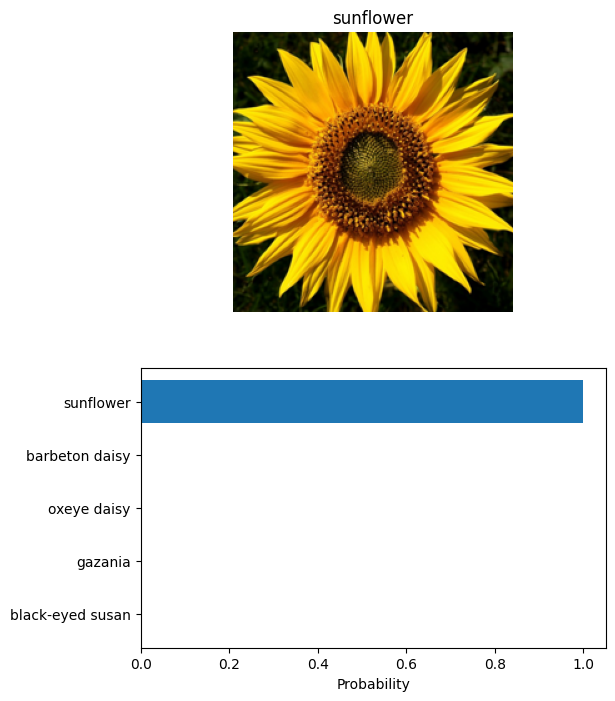

In [29]:
# Call the function to display the predicted class of the input image in a chart
image_path = 'assets/img-check.jpg'
plot_predictions(image_path, model, cat_to_name)